# Set UP

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# Load Data 

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
data['ID'].unique()

array(['06EB002', '08MG012', '05RE003', '05SB006', '05SD002', '05SG001',
       '05RF001', '05SD001', '05SA003', '05LH001', '05LK002', '05LL012',
       '02DD006', '05MD009', '05PD029', '05PE014', '05LM005', '02JE011',
       '05RD005', '07EA007', '05TG005', '02YF002', '05KL005', '05AB037',
       '02OH001', '08MH149', '05KK002', '02YL009', '05UD001', '05LJ009',
       '02YL007', '08NH127', '06EB007', '05RD006', '05TF001', '01AO010',
       '05CB006', '01AR013', '01AR009', '01AO003', '02YK010', '05ND012',
       '02HB021', '02JD013', '02GA030', '08LG046', '05KK005', '05PF070',
       '08NM083', '05AA032', '02JE024', '02LA015', '02OA013', '08FA007',
       '05QC004', '05UB005', '06EA012', '08KH011', '05NB032', '05PB024',
       '05PB007', '05TF004'], dtype=object)

In [4]:
example = data[data['ID'] == '05RE003']

In [5]:
example.head()

,Date,ID,PARAM,Value,Latitude,Longitude
14608,2000-01-02,05RE003,2,217.434,52.81842,-97.61956
14609,2000-01-03,05RE003,2,217.442,52.81842,-97.61956
14610,2000-01-04,05RE003,2,217.440,52.81842,-97.61956
14611,2000-01-05,05RE003,2,217.438,52.81842,-97.61956
14612,2000-01-06,05RE003,2,217.435,52.81842,-97.61956


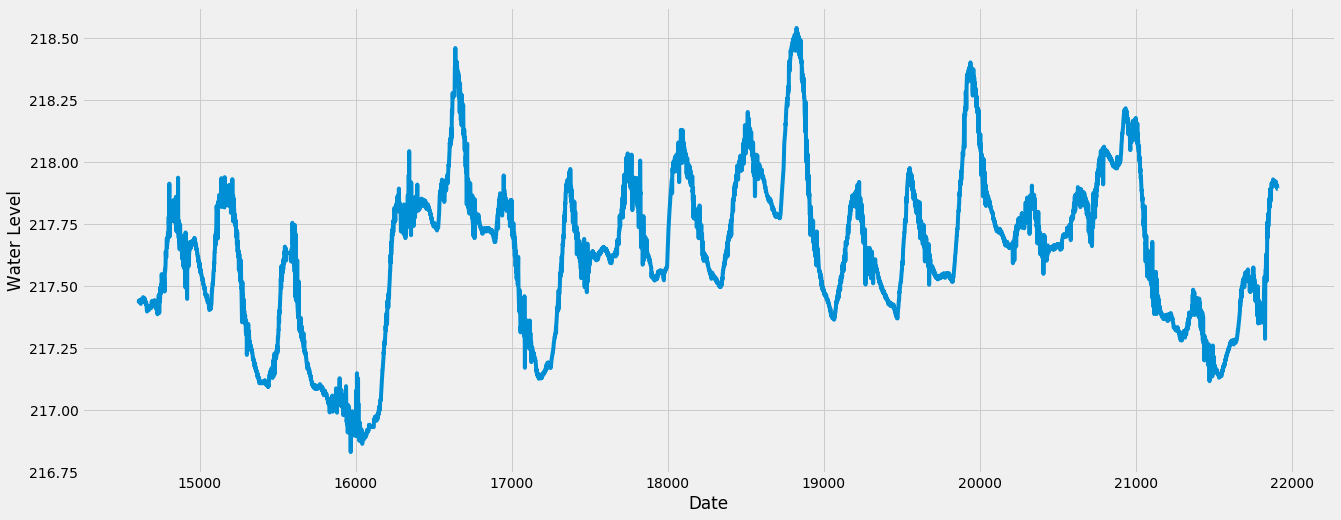

In [6]:
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.plot(example["Value"])
plt.show()

### Stationarity 

in the time series forecasting, we search usually for a stationary series. The series should have a constant mean, variance, and covariance.

so let's check if the  Water Level series is stationary or not. to do this i will use ADF (Augmented Dickey-Fuller) Test :

* Null Hypothesis: The series has a unit root
* Alternate Hypothesis: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary.

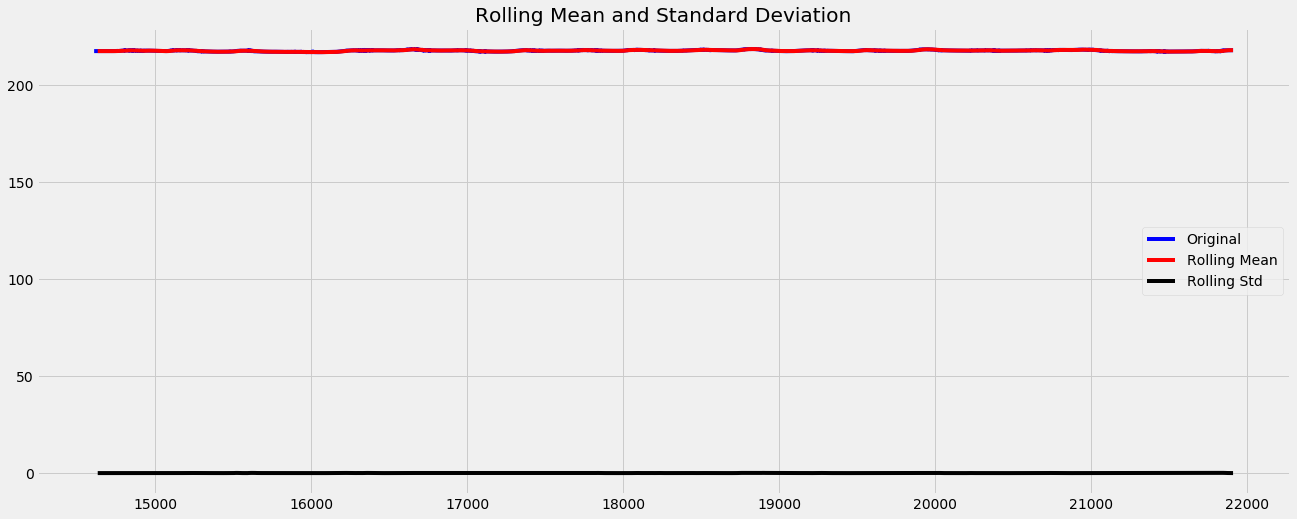

Results of dickey fuller test
Test Statistics                  -5.300091
p-value                           0.000005
No. of lags used                 36.000000
Number of observations used    7267.000000
critical value (1%)              -3.431250
critical value (5%)              -2.861938
critical value (10%)             -2.566982
dtype: float64


In [7]:
test_stationarity(example["Value"])

Through the above graph,The series have a constant mean and variance. and the p-value is less than 0.05 so we can reject the Null hypothesis. so the data is stationary.

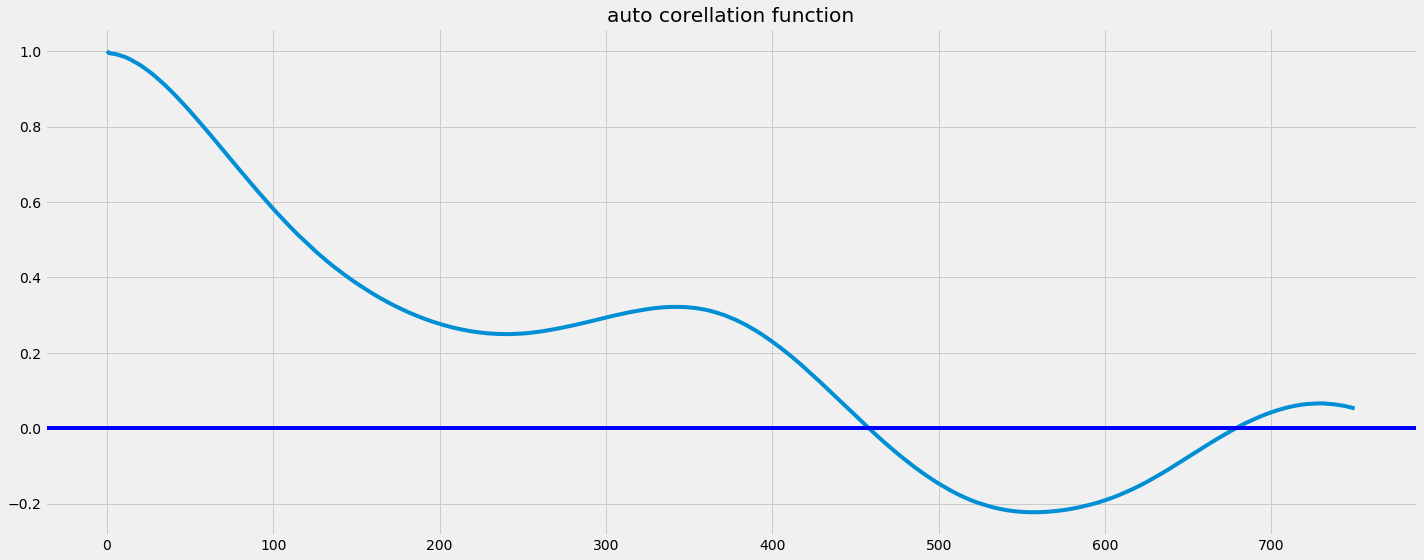

In [8]:
# we use d value here(data_log_shift)
_acf = acf(example['Value'], nlags=750)
#plot ACF
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('auto corellation function')
plt.tight_layout()

### Target Distribution 

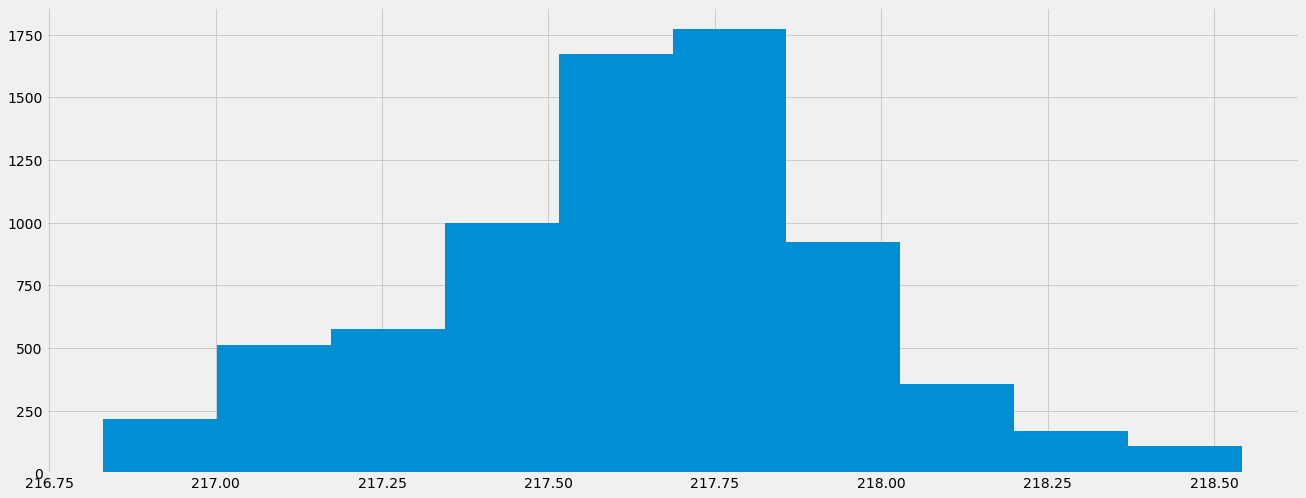

In [9]:
(example['Value']).hist()

# Anomaly Detection 

## Isolation Forests For Anomaly Detection

Isolation Forest detects anomalies purely based on the fact that anomalies are data points that are few and different. The anomalies isolation is implemented without employing any distance or density measure. 

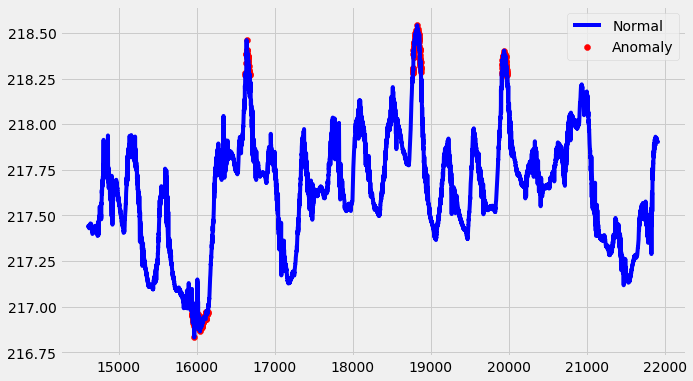

In [11]:
outliers_fraction = 0.05
data = example[['Value']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
example['anomaly2'] = pd.Series(model.predict(data)).values

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = example.loc[example['anomaly2'] == -1, ['Value']] #anomaly

ax.plot(example.index , example['Value'], color='blue', label = 'Normal')
ax.scatter(a.index , a['Value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();